# Notebook 3 - Explicação do modelo

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) e [Guilherme Silveira](https://github.com/guiasilveira)

<a id='1'></a>
##  Configurações iniciais

### Importação de bibliotecas

Bibliotecas e funções utilizadas neste notebook. Leia a seção [Versões do Software](https://github.com/fnaghetini/Mapa-Preditivo) para conferir as versões das bibliotecas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functions.Custom_Train_Test_Split import customTrainTestSplit
from sklearn.preprocessing import StandardScaler
from functions.Custom_Preprocessing import MaskedPCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/data_nb3.csv",sep=",")
df = df_original.copy(deep = True)
df.head(10)

,X,Y,GT,K,TH,U,U_K,TH_K,U_TH,MDT,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.11,6.51,0.49,1435.25,...,15656,11371,7669,5089,208,199,185,6,Fm_GM,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.11,6.91,0.47,1433.84,...,17906,13743,8706,5077,195,189,169,6,Fm_GM,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,2.72,6.97,0.41,1430.14,...,17693,13716,8699,5083,197,160,153,6,Fm_GM,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,2.40,7.16,0.36,1425.73,...,16064,11973,8334,5083,226,208,202,6,Fm_GM,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,2.21,7.50,0.33,1421.32,...,15789,11648,8081,5085,161,167,130,6,Fm_GM,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,2.51,7.64,0.36,1422.72,...,15269,11403,8028,5079,142,107,106,6,Fm_GM,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.14,7.37,0.44,1432.31,...,18497,14848,9045,5091,226,175,200,6,Fm_GM,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,2.80,7.47,0.40,1427.89,...,16202,12264,8508,5097,170,107,122,6,Fm_GM,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.18,7.87,0.42,1430.14,...,17907,14332,8848,5082,224,150,198,6,Fm_GM,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,2.87,7.93,0.38,1425.09,...,15765,11898,8060,5098,243,171,217,6,Fm_GM,PP4egm


<a id='2'></a>
## Separação entre treino e teste

In [3]:
FEAT  = ['GT','K','TH','U','U_K','TH_K','U_TH','MDT','B01','B02','B03','B04','B05','B06','B07','R','G','B']
COORD = ['X','Y']

In [4]:
X_train, y_train, X_test, y_test = customTrainTestSplit(df, FEAT, COORD, samp_per_class = 100, threshold = 0.7)

<a id='3'></a>
## Pré-processamento

### Escalonamento das features

In [5]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

### Redução da dimensionalidade

In [6]:
mask = np.arange(8,18)
pca = MaskedPCA(n_components = 3, mask = mask)
X_train_pca = pca.fit_transform(X_train_std)

In [7]:
# Aualização das features
FEAT = list(FEAT[:8] + ['PC'+str(i) for i in range(1,4)])

### Seleção das features

In [8]:
selector = SelectKBest(score_func = f_classif, k = 10)
X_train_sel = selector.fit_transform(X_train_pca, y_train)

In [9]:
# Atualização das features
feat_bool_index = selector.get_support()
feat_length = len(FEAT)
FEAT = [FEAT[i] for i in range(feat_length) if feat_bool_index[i]]

### Superamostragem

In [10]:
smote = SMOTE()
X_train_smt, y_train_smt = smote.fit_resample(X_train_sel, y_train)

<a id='4'></a>
## Modelagem dos dados

In [11]:
clf = XGBClassifier(subsample = 0.9, reg_lambda = 0.001, min_child_weight = 1, eval_metric = 'mlogloss',
                    max_depth = 12, learning_rate = 0.15, gamma = 0.9, verbosity = 0,
                    eta = 0.05, colsample_bytree = 0.9, alpha = 0.01, random_state = 42)

clf.fit(X_train_smt, y_train_smt);

<a id='5'></a>
## Explicação do modelo

In [12]:
X_train_with_col_names = pd.DataFrame(X_train_smt, columns=FEAT)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_with_col_names)

In [13]:
dic_lith = {0 : 'Cx_GG',
            1 : 'Fm_BG',
            2 : 'Fm_B',
            3 : 'Fm_SJC',
            4 : 'Fm_SB',
            5 : 'Fm_GM'}

### Summary plot

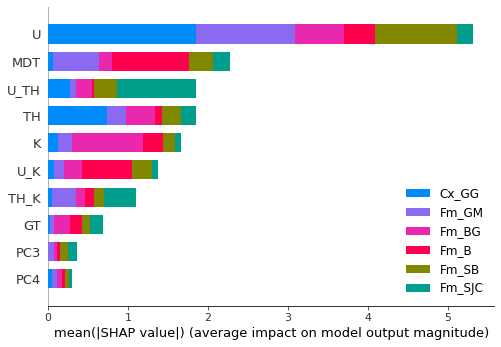

In [14]:
shap.summary_plot(shap_values, X_train_with_col_names, plot_type="bar", class_names = dic_lith)

Cx_GG


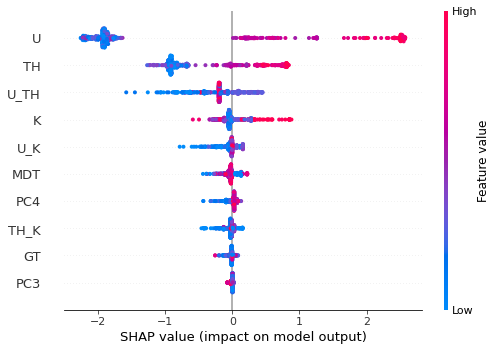

Fm_BG


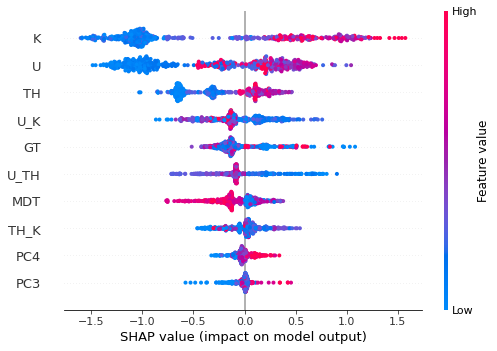

Fm_B


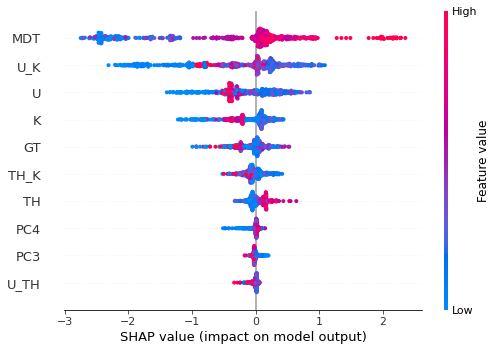

Fm_SJC


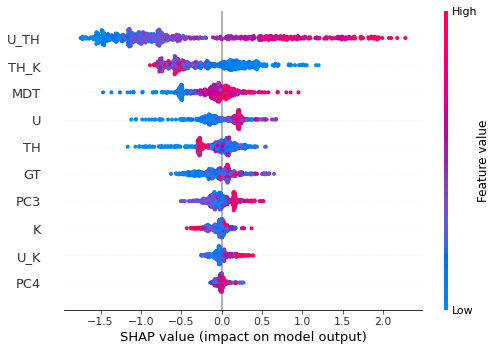

Fm_SB


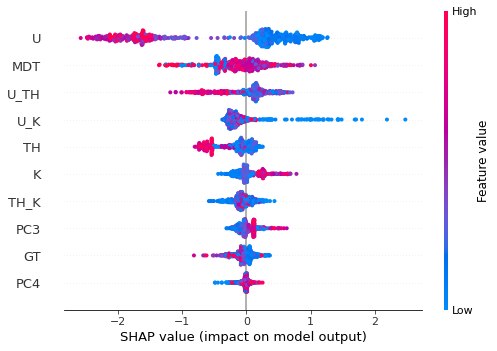

Fm_GM


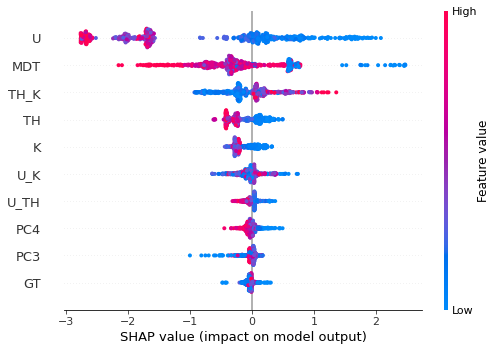

In [15]:
for i in range(6):
    print(dic_lith[i])
    shap.summary_plot(shap_values[i],X_train_with_col_names)

### Dependence plot

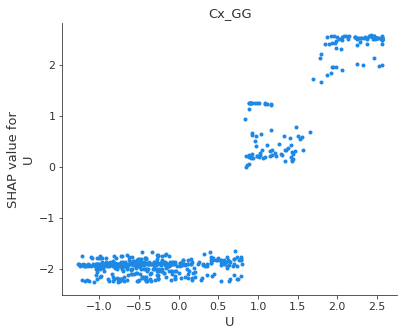

In [16]:
shap.dependence_plot("U", shap_values[0], X_train_with_col_names, interaction_index=None,
                     title=f"{dic_lith[0]}")

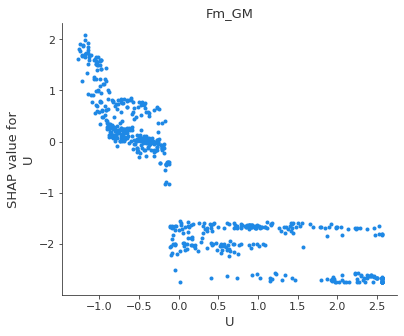

In [17]:
shap.dependence_plot("U", shap_values[5], X_train_with_col_names, interaction_index=None,
                     title=f"{dic_lith[5]}")

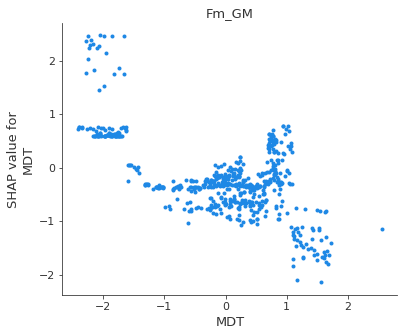

In [18]:
shap.dependence_plot("MDT", shap_values[5], X_train_with_col_names, interaction_index=None,
                     title=f"{dic_lith[5]}")

### Force plot

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train_with_col_names.iloc[1,:])

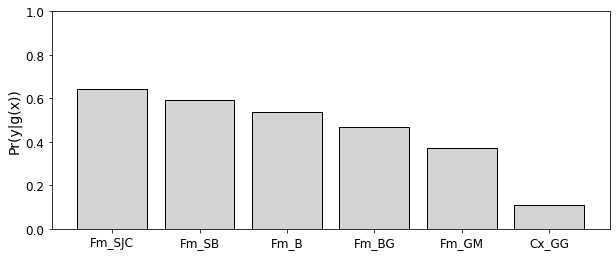

In [31]:
expected_values = [explainer.expected_value[i] for i in range(6)]

dic_expected_values = {'CLASS' : list(dic_lith.values()), 'E' : expected_values}
df_expected_values = pd.DataFrame(dic_expected_values).sort_values('E', ascending = False)

plt.figure(figsize=(10,4))
plt.bar('CLASS', 'E', data = df_expected_values, color = 'lightgray', edgecolor = 'black')
plt.ylabel('Pr(y|g(x))', size=14)
plt.xticks(size=12)
plt.yticks(np.arange(0,1.2,0.2), size=12);